In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
words = open('names_jp.txt', 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

block_size = 4

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size

    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)

  print(X.shape, Y.shape)

  return X, Y
  
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

trainX, trainY = build_dataset(words[:n1])
devX, devY = build_dataset(words[n1:n2])
testX, testY = build_dataset(words[n2:])

torch.Size([2023, 4]) torch.Size([2023])
torch.Size([251, 4]) torch.Size([251])
torch.Size([256, 4]) torch.Size([256])


In [ ]:
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((len(stoi), 10), generator=g)

W1 = torch.randn((block_size * 10, 30), generator=g)
b1 = torch.randn(30, generator=g)

W2 = torch.randn((30, len(stoi)), generator=g)
b2 = torch.randn(len(stoi), generator=g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
  p.requires_grad = True

print(sum(p.nelement() for p in parameters))

1838


In [ ]:
lossi = []
stepi = []

In [ ]:
for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, trainX.shape[0], (64,))

  # forward pass
  emb = C[trainX[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size * 10) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, trainY[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  stepi.append(i)
  lossi.append(loss.log10().item())


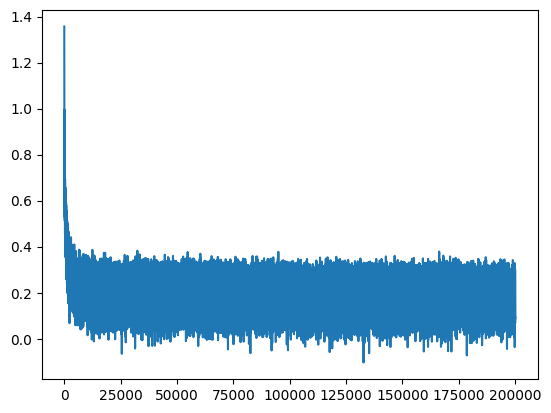

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
# train loss
emb = C[trainX] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 10) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, trainY)
loss

tensor(2.2935, grad_fn=<NllLossBackward0>)

In [ ]:
# test loss
emb = C[testX] # (32, 3, 2)
h = torch.tanh(emb.view(-1, block_size * 10) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, testY)
loss

tensor(3.5723, grad_fn=<NllLossBackward0>)

In [ ]:
# sample from the model
g = torch.Generator()

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

るこ.
ひぼかよ.
かいこ.
となこ.
まえみ.
れい.
ふんじ.
おさは.
きずし.
しとぱ.
ゆめじ.
まとでん.
あきよし.
あきふい.
まい.
あいこ.
かきじよ.
ます.
しあ.
かたのけ.
